# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import pickle
import shutil
import os

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s5e3/train.csv'
    test_path = '/kaggle/input/playground-series-s5e3/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s5e3/sample_submission.csv'
    
    original_path = "/kaggle/input/hongkongrainfall/hongkong.csv"
    original_path_2 = "/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv"
    
    target = 'rainfall'
    n_folds = 10
    seed = 2100
    time_limit = 3600 * 11

    pipeline = 2

# Loading data and predefining folds

In [3]:
def get_data(pipeline):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")

    test.winddirection = test.winddirection.fillna(test.winddirection.median())
    
    if pipeline == 1:
        return train, test, None
    
    original = pd.read_csv(CFG.original_path, encoding="gbk")
    original["date"] = pd.to_datetime(original[["year", "month", "day"]])
    original = original.drop(["year", "month", "day", "low visibility hour", "radiation", "evaporation"], axis=1)
    original["day"] = original.date.dt.dayofyear
    original = original.drop("date", axis=1)
    original.rainfall = original.rainfall.apply(lambda x: 1 if str(x).replace('.', '', 1).isdigit() else x)
    original.rainfall = original.rainfall.replace({'微量': 1, '-': 0}).astype(int)
    original.sunshine = original.sunshine.replace('-', 0).astype(float)
    original.windspeed = original.windspeed.fillna(original.windspeed.mean())
    for col in original.columns:
        original[col] = original[col].astype(train[col].dtype)
        
    if pipeline == 2:
        return train, test, original
        
    original_2 = pd.read_csv(CFG.original_path_2)
    original_2.columns = original_2.columns.str.replace(" ", "")
    original_2[CFG.target] = original_2[CFG.target].map({"yes": 1, "no": 0})
    original_2.winddirection = original_2.winddirection.fillna(original_2.winddirection.mean())
    original_2.windspeed = original_2.windspeed.fillna(original_2.windspeed.mean())
    original_2.day = original_2.index + 1
    for col in original_2.columns:
        original_2[col] = original_2[col].astype(train[col].dtype)
        
    if pipeline == 3:
        return train, test, original_2
        
    original_combined = pd.concat([original, original_2], axis=0).reset_index(drop=True)
    original_combined = original_combined.drop_duplicates().reset_index(drop=True)

    return train, test, original_combined

In [4]:
train, test, original = get_data(CFG.pipeline)

In [5]:
skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = skf.split(train, train[CFG.target])
for i, (_, val_index) in enumerate(split):
    train.loc[val_index, 'fold'] = i

# Fitting the predictor

In [6]:
predictor = TabularPredictor(
    path='/AutoGluonModels',
    problem_type='binary',
    eval_metric='roc_auc',
    label=CFG.target,
    groups='fold',
    verbosity=2
)

In [7]:
if original is None:
    predictor.fit(
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )
else:
    predictor.fit_pseudolabel(
        pseudo_data=original,
        train_data=train,
        time_limit=CFG.time_limit,
        presets='best_quality'
    )

Predictor not fit prior to pseudolabeling. Fitting now...
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       30.17 GB / 31.35 GB (96.2%)
Disk Space Avail:   1892.13 GB / 8062.39 GB (23.5%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the

(_ray_fit pid=7368) [1000]	valid_set's binary_logloss: 0.300476
(_ray_fit pid=7497) [1000]	valid_set's binary_logloss: 0.346226 [repeated 8x across cluster]
(_ray_fit pid=7662) [1000]	valid_set's binary_logloss: 0.320026 [repeated 2x across cluster]


(_dystack pid=166) 	0.8987	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.66s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r22_BAG_L1 ... Training model for up to 6194.28s of the 9494.68s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8961	 = Validation score   (roc_auc)
(_dystack pid=166) 	34.75s	 = Training   runtime
(_dystack pid=166) 	0.16s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r33_BAG_L1 ... Training model for up to 6156.62s of the 9457.02s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.12%)
(_dystack pid=166) 	0.8885	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.54s	 = Training   runtime
(_dystack pid

(_ray_fit pid=17314) [1000]	valid_set's binary_logloss: 0.35315
(_ray_fit pid=17317) [1000]	valid_set's binary_logloss: 0.331665
(_ray_fit pid=17449) [1000]	valid_set's binary_logloss: 0.349358 [repeated 6x across cluster]
(_ray_fit pid=17582) [1000]	valid_set's binary_logloss: 0.321727 [repeated 3x across cluster]


(_dystack pid=166) 	0.897	 = Validation score   (roc_auc)
(_dystack pid=166) 	19.52s	 = Training   runtime
(_dystack pid=166) 	0.5s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r39_BAG_L1 ... Training model for up to 5471.43s of the 8771.84s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8823	 = Validation score   (roc_auc)
(_dystack pid=166) 	17.82s	 = Training   runtime
(_dystack pid=166) 	0.96s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r167_BAG_L1 ... Training model for up to 5450.68s of the 8751.08s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.8944	 = Validation sc

(_ray_fit pid=24187) [1000]	valid_set's binary_logloss: 0.294527 [repeated 5x across cluster]


(_dystack pid=166) 	0.8978	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.93s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r143_BAG_L1 ... Training model for up to 4957.62s of the 8258.02s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.00%)
(_dystack pid=166) 	0.8929	 = Validation score   (roc_auc)
(_dystack pid=166) 	43.33s	 = Training   runtime
(_dystack pid=166) 	0.14s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r128_BAG_L1 ... Training model for up to 4911.23s of the 8211.63s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=166) 	0.8928	 = Validation score   (roc_auc)
(_dystack pid=166) 	32.98s	 = Training   runtime
(_dystack p

(_ray_fit pid=27517) [1000]	valid_set's binary_logloss: 0.304081
(_ray_fit pid=27516) [1000]	valid_set's binary_logloss: 0.296375
(_ray_fit pid=27782) [1000]	valid_set's binary_logloss: 0.317417


(_dystack pid=166) 	0.8967	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.77s	 = Training   runtime
(_dystack pid=166) 	0.23s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r49_BAG_L1 ... Training model for up to 4699.53s of the 7999.93s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.03%)
(_dystack pid=166) 	0.8913	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.17s	 = Training   runtime
(_dystack pid=166) 	0.08s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r5_BAG_L1 ... Training model for up to 4687.54s of the 7987.94s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.87s	 = Training   runtime
(_dystack pid=166) 	0

(_ray_fit pid=50648) [1000]	valid_set's binary_logloss: 0.272771
(_ray_fit pid=50648) [2000]	valid_set's binary_logloss: 0.272125
(_ray_fit pid=50648) [3000]	valid_set's binary_logloss: 0.270808
(_ray_fit pid=50648) [4000]	valid_set's binary_logloss: 0.270575
(_ray_fit pid=50773) [1000]	valid_set's binary_logloss: 0.336464


(_dystack pid=166) 	0.9044	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.18s	 = Training   runtime
(_dystack pid=166) 	0.2s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 6478.74s of the 6478.50s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=166) 	40.86s	 = Training   runtime
(_dystack pid=166) 	0.24s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 6435.01s of the 6434.77s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.24%)
(_dystack pid=166) 	0.9021	 = Validation score   (roc_auc)
(_dystack pid=166) 	16.13s	 = Training   runtime
(_dystack pid=

(_ray_fit pid=60600) [1000]	valid_set's binary_logloss: 0.296546
(_ray_fit pid=60728) [1000]	valid_set's binary_logloss: 0.337676 [repeated 4x across cluster]
(_ray_fit pid=60861) [1000]	valid_set's binary_logloss: 0.286556
(_ray_fit pid=60893) [1000]	valid_set's binary_logloss: 0.32237


(_dystack pid=166) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=166) 	20.18s	 = Training   runtime
(_dystack pid=166) 	0.41s	 = Validation runtime
(_dystack pid=166) Fitting model: RandomForest_r39_BAG_L2 ... Training model for up to 5665.88s of the 5665.64s of remaining time.
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_ray_fit pid=60547) No improvement since epoch 13: early stopping
(_dystack pid=166) 	0.8971	 = Validation score   (roc_auc)
(_dystack pid=166) 	30.98s	 = Training   runtime
(_dystack pid=166) 	1.06s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r167_BAG_L2 ... Training model for up to 5631.66s of the 5631.42s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus

(_ray_fit pid=67605) [1000]	valid_set's binary_logloss: 0.33728


(_dystack pid=166) 	0.9047	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.68s	 = Training   runtime
(_dystack pid=166) 	0.09s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r143_BAG_L2 ... Training model for up to 5029.20s of the 5028.96s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)
(_dystack pid=166) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=166) 	72.21s	 = Training   runtime
(_dystack pid=166) 	0.28s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r128_BAG_L2 ... Training model for up to 4954.01s of the 4953.77s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.62%)
(_dystack pid=166) 	0.902	 = Validation score   (roc_auc)
(_dystack pid=166) 	74.33s	 = Training   runtime
(_dystack p

(_ray_fit pid=70806) [1000]	valid_set's binary_logloss: 0.267845
(_ray_fit pid=70806) [2000]	valid_set's binary_logloss: 0.264825
(_ray_fit pid=70936) [1000]	valid_set's binary_logloss: 0.335016


(_dystack pid=166) 	0.9027	 = Validation score   (roc_auc)
(_dystack pid=166) 	15.8s	 = Training   runtime
(_dystack pid=166) 	0.22s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r49_BAG_L2 ... Training model for up to 4692.78s of the 4692.54s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.33%)
(_dystack pid=166) 	0.9026	 = Validation score   (roc_auc)
(_dystack pid=166) 	11.46s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r5_BAG_L2 ... Training model for up to 4678.00s of the 4677.76s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=166) 	0.9035	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.2s	 = Training   runtime
(_dystack pid=166) 	0.0

(autoscaler +1h41m15s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1h41m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=82676) No improvement since epoch 4: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.9017	 = Validation score   (roc_auc)
(_dystack pid=166) 	26.44s	 = Training   runtime
(_dystack pid=166) 	0.11s	 = Validation runtime
(_dystack pid=166) Fitting model: ExtraTrees_r126_BAG_L2 ... Training model for up to 3810.04s of the 3809.80s of remaining time.
(_ray_fit pid=82672) No improvement since epoch 18: early stopping [repeated 3x across cluster]
(_dystack pid=166) 	Forcing `use_child_oof=False` because `groups` is specified
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.01%)
(_dystack pid=166) 	0.9014	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.49s	 = Training   runtime
(_dystack pid=166) 	0.82s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r36_BAG_L2 ... Training model for up to 3794.26s of the 3794.02s of remaining time.


(autoscaler +1h41m50s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9003	 = Validation score   (roc_auc)
(_dystack pid=166) 	39.17s	 = Training   runtime
(_dystack pid=166) 	0.25s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r100_BAG_L2 ... Training model for up to 3752.25s of the 3752.01s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h42m30s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83790) No improvement since epoch 11: early stopping


(autoscaler +1h43m5s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(autoscaler +1h43m40s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_ray_fit pid=83970) No improvement since epoch 11: early stopping
(_ray_fit pid=84002) No improvement since epoch 9: early stopping
(_ray_fit pid=84188) No improvement since epoch 9: early stopping [repeated 2x across cluster]
(_dystack pid=166) 	0.8927	 = Validation score   (roc_auc)
(_dystack pid=166) 	96.51s	 = Training   runtime
(_dystack pid=166) 	0.34s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r163_BAG_L2 ... Training model for up to 3652.67s of the 3652.43s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.10%)


(autoscaler +1h44m15s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9042	 = Validation score   (roc_auc)
(_dystack pid=166) 	14.02s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: CatBoost_r198_BAG_L2 ... Training model for up to 3635.48s of the 3635.24s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.17%)
(_dystack pid=166) 	0.9045	 = Validation score   (roc_auc)
(_dystack pid=166) 	21.59s	 = Training   runtime
(_dystack pid=166) 	0.04s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetFastAI_r187_BAG_L2 ... Training model for up to 3611.04s of the 3610.79s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.04%)


(autoscaler +1h44m55s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.8973	 = Validation score   (roc_auc)
(_dystack pid=166) 	23.57s	 = Training   runtime
(_dystack pid=166) 	0.12s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r19_BAG_L2 ... Training model for up to 3584.70s of the 3584.46s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h45m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	25.36s	 = Training   runtime
(_dystack pid=166) 	0.27s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r95_BAG_L2 ... Training model for up to 3556.45s of the 3556.21s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.18%)
(_dystack pid=166) 	0.9019	 = Validation score   (roc_auc)
(_dystack pid=166) 	9.78s	 = Training   runtime
(_dystack pid=166) 	0.07s	 = Validation runtime
(_dystack pid=166) Fitting model: XGBoost_r34_BAG_L2 ... Training model for up to 3543.64s of the 3543.40s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=1.23%)


(autoscaler +1h46m6s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9015	 = Validation score   (roc_auc)
(_dystack pid=166) 	12.19s	 = Training   runtime
(_dystack pid=166) 	0.1s	 = Validation runtime
(_dystack pid=166) Fitting model: LightGBM_r42_BAG_L2 ... Training model for up to 3528.60s of the 3528.36s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.49%)
(_dystack pid=166) 	0.9036	 = Validation score   (roc_auc)
(_dystack pid=166) 	13.34s	 = Training   runtime
(_dystack pid=166) 	0.05s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r1_BAG_L2 ... Training model for up to 3512.45s of the 3512.21s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h46m41s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.906	 = Validation score   (roc_auc)
(_dystack pid=166) 	44.92s	 = Training   runtime
(_dystack pid=166) 	0.37s	 = Validation runtime
(_dystack pid=166) Fitting model: NeuralNetTorch_r89_BAG_L2 ... Training model for up to 3464.45s of the 3464.21s of remaining time.
(_dystack pid=166) 	Fitting 10 child models (S1F1 - S1F10) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=1, gpus=0, memory=0.02%)


(autoscaler +1h47m21s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(_dystack pid=166) 	0.9011	 = Validation score   (roc_auc)
(_dystack pid=166) 	41.68s	 = Training   runtime
(_dystack pid=166) 	0.3s	 = Validation runtime
(_dystack pid=166) Fitting model: WeightedEnsemble_L3 ... Training model for up to 692.16s of the 3419.49s of remaining time.
(_dystack pid=166) 	Ensemble Weights: {'XGBoost_r89_BAG_L2': 0.208, 'CatBoost_r180_BAG_L2': 0.208, 'NeuralNetTorch_r135_BAG_L2': 0.208, 'NeuralNetFastAI_r102_BAG_L2': 0.167, 'NeuralNetTorch_r41_BAG_L2': 0.125, 'NeuralNetFastAI_r111_BAG_L2': 0.083}
(_dystack pid=166) 	0.9129	 = Validation score   (roc_auc)
(_dystack pid=166) 	0.22s	 = Training   runtime
(_dystack pid=166) 	0.0s	 = Validation runtime
(_dystack pid=166) AutoGluon training complete, total runtime = 6477.09s ... Best model: WeightedEnsemble_L3 | Estimated inference throughput: 32.4 rows/s (195 batch size)
(_dystack pid=166) TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/AutoGluonModels/ds_sub_fit/sub_fit_ho")
(_dystack pi

In [8]:
def get_ensemble_weights(predictor):
    selected_models = []
    info = predictor.info()
    ensemble_weights = {}
    for model_name, values in info["model_info"].items():
        if "Ensemble" in model_name:
            children_info = values["children_info"]
            ensemble_weights[model_name] = values["children_info"][list(children_info.keys())[0]]["model_weights"]
            selected_models.extend(values["children_info"][list(children_info.keys())[0]]["model_weights"].keys())
            selected_models.append(model_name)
    return ensemble_weights, list(set(selected_models))

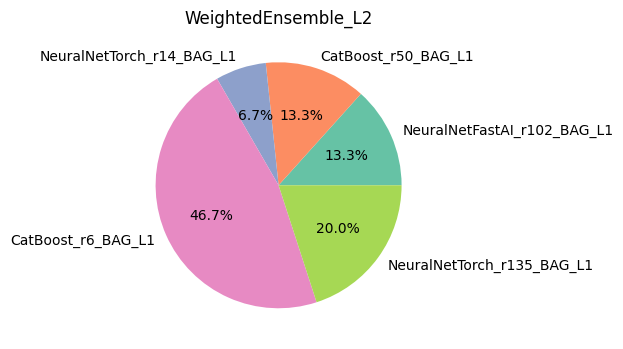

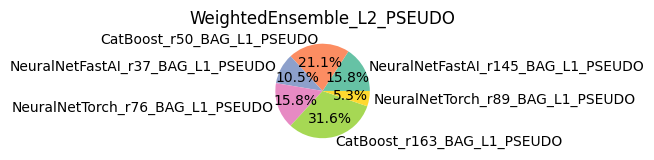

In [9]:
ensemble_weights, selected_models = get_ensemble_weights(predictor)

for key, value in ensemble_weights.items():
    plt.figure(figsize=(6, 6))
    plt.pie(value.values(), labels=value.keys(), autopct='%1.1f%%', colors=sns.color_palette('Set2', len(value)))
    plt.title(key)
    plt.tight_layout()
    plt.show()

In [10]:
predictor.leaderboard(silent=True)[predictor.leaderboard(silent=True).model.isin(selected_models)].style.background_gradient(subset=['score_val'], cmap='RdYlGn')

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.902516,roc_auc,0.555313,168.576825,0.001060,0.249456,2,True,111
1,WeightedEnsemble_L2_PSEUDO,0.902453,roc_auc,0.749993,303.158633,0.000674,0.195266,2,True,222
2,CatBoost_r6_BAG_L1,0.899394,roc_auc,0.022222,12.893495,0.022222,12.893495,1,True,85
3,CatBoost_r50_BAG_L1_PSEUDO,0.899388,roc_auc,0.036891,15.183763,0.036891,15.183763,1,True,144
4,CatBoost_r163_BAG_L1_PSEUDO,0.899227,roc_auc,0.019047,14.193030,0.019047,14.193030,1,True,213
6,CatBoost_r50_BAG_L1,0.899127,roc_auc,0.018197,12.494509,0.018197,12.494509,1,True,33
12,NeuralNetFastAI_r37_BAG_L1_PSEUDO,0.897972,roc_auc,0.156432,45.802083,0.156432,45.802083,1,True,164
26,NeuralNetTorch_r89_BAG_L1_PSEUDO,0.897103,roc_auc,0.153489,108.777618,0.153489,108.777618,1,True,221
27,NeuralNetFastAI_r145_BAG_L1_PSEUDO,0.897068,roc_auc,0.269257,71.429292,0.269257,71.429292,1,True,139
36,NeuralNetTorch_r76_BAG_L1_PSEUDO,0.896523,roc_auc,0.114204,47.577581,0.114204,47.577581,1,True,201


# Collecting and saving OOF files

In [11]:
def save_pred_probs(pred_probs, cv_score, name, type, is_ensemble):
    base_path = 'oof_pred_probs' if type == 'oof' else 'test_pred_probs'
    base_path = '.' if is_ensemble else base_path
    with open(f'{base_path}/{name}_{type}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
        pickle.dump(pred_probs, f)

def save_submission(test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_autogluon_{score:.6f}.csv', index=False)
    
os.makedirs('oof_pred_probs', exist_ok=True)
os.makedirs('test_pred_probs', exist_ok=True)

In [12]:
oof_pred_probs = {}
test_pred_probs = {}

In [13]:
best_model = predictor.model_best
test_pred_probs = predictor.predict_proba_multi(test)
for model in predictor.model_names():
    model_oof_pred_probs = predictor.predict_proba_oof(model).values[:, 1]
    model_test_pred_probs = test_pred_probs[model].values[:, 1]
    
    cv_score = roc_auc_score(train[CFG.target], model_oof_pred_probs)
    if model != best_model:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', False)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', False)
    else:
        save_pred_probs(model_oof_pred_probs, cv_score, model, 'oof', True)
        save_pred_probs(model_test_pred_probs, cv_score, model, 'test', True)
        save_submission(model_test_pred_probs, cv_score)
        
    oof_pred_probs[model] = model_oof_pred_probs
    test_pred_probs[model] = model_test_pred_probs

INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.predict_proba: running accelerated version on CPU
INFO:sklearnex: sklearn.neighbors.KNeighborsClassifier.

# Visualizing the results

In [14]:
scores = {}
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(train, train[CFG.target])
for fold_idx, (train_index, val_index) in enumerate(split):
    for model in predictor.model_names():
        fold_score = roc_auc_score(train.loc[val_index, CFG.target], oof_pred_probs[model][val_index])
        if model not in scores:
            scores[model] = []
        scores[model].append(fold_score)

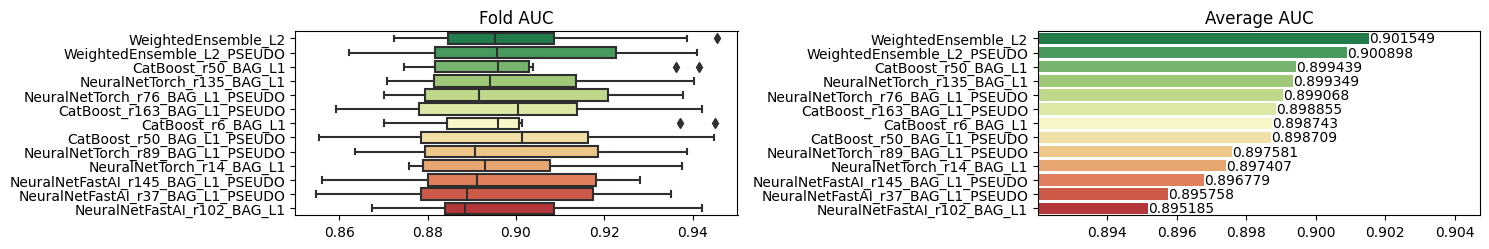

In [15]:
scores = pd.DataFrame(scores)[selected_models]
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.2))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()